In [ ]:
#@title Import Dependencies
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
from os.path import join
from datetime import datetime, timezone

import os, sys
module_path = "/content/drive/MyDrive/Adaptive Smoothing"
if module_path not in sys.path:
    sys.path.append(module_path)
from models.base_models.small_rn import ResNet18
from models.base_models.trade_wrn import WideResNet
from visualizations.compare_grad_helper import (
    ConvNextTforCIFAR, SimpleCompositeModel, load_model,
    get_dataloaders, eval_base, eval_comp, plot_results)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

# Reproducibility
import random
random.seed(20221105)  # 20220304
torch.manual_seed(20221105)
np.random.seed(20221105)

In [3]:
#@title Run evaluations
def run_evals(std_model, adv_model, comp_model_setting,
              alpha_setting, pgd_setting, batch_size, img_per_class, save_dir):
    timestr = str(datetime.now(timezone.utc).isoformat()).split(".")[0]
    timestr = timestr.replace("T", "").replace("-", "").replace(":", "")
    save_dir = save_dir + timestr
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    trainloader, testloader = get_dataloaders(batch_size, img_per_class)
    base_acc = eval_base(std_model, adv_model, testloader, pgd_setting)

    alphas = {}
    for typ in ["Clean", "STD", "ADV", "Comp"]:
        alphas[typ] = list(np.logspace(
            alpha_setting["min"], alpha_setting["max"],
            alpha_setting["num"][typ]))

    comp_model = SimpleCompositeModel(std_model, adv_model, comp_model_setting)
    comp_acc = eval_comp(comp_model, testloader, alphas, pgd_setting)

    save_dic = {"alpha_setting": alpha_setting,
                "comp_model_setting": comp_model_setting,
                "pgd_setting": pgd_setting,
                "base_acc": base_acc,
                "comp_acc": comp_acc}
    
    plot_results(alphas, base_acc, comp_acc, save_dir, pgd_type=pgd_setting["type"])
    with open(join(save_dir, "results.json"), 'w') as f:
        json.dump(save_dic, f)

# Experiments

## TRADE ConvNeXTT+WRN34 Linf

Files already downloaded and verified
Number of test images: 2000.
Files already downloaded and verified
Evaluating the STD model.


100%|██████████| 25/25 [01:05<00:00,  2.64s/it, CleanAcc=97.2, AttackedAcc=0]


Accuracy of the STD model on 10000 Clean test images: 97.250 %.
Accuracy of the STD model on 10000 Attacked test images: 0.000 %.
Evaluating the ADV model.


100%|██████████| 25/25 [00:19<00:00,  1.25it/s, CleanAcc=85.5, AttackedAcc=57.5]


Accuracy of the ADV model on 10000 Clean test images: 85.550 %.
Accuracy of the ADV model on 10000 Attacked test images: 57.500 %.
Evaluating the adaptively smoothed model.
Attack targeting base models.


100%|██████████| 25/25 [01:31<00:00,  3.65s/it]


Accuracy of the smoothed model with Clean data: 
[97.25, 97.25, 97.25, 97.25, 97.25, 97.25, 97.25, 97.3, 97.3, 97.3, 97.3, 97.3, 97.35000000000001, 97.45, 97.55, 97.55, 97.55, 97.55, 97.5, 97.35000000000001, 97.2, 96.7, 96.55, 96.1, 95.3, 95.0, 93.65, 92.30000000000001, 91.5, 90.4, 89.05, 88.25, 87.5, 86.85000000000001, 86.6, 86.35000000000001, 86.05000000000001, 85.85000000000001, 85.85000000000001, 85.85000000000001, 85.8, 85.7, 85.65, 85.65, 85.65, 85.65, 85.65, 85.65, 85.65, 85.55].
Accuracy of the smoothed model with STD data: 
[0.0, 0.0, 0.05, 0.05, 0.1, 0.1, 0.15, 0.2, 0.35000000000000003, 0.7000000000000001, 0.8999999999999999, 1.15, 1.4500000000000002, 1.95, 2.3, 2.8000000000000003, 3.6999999999999997, 5.0, 5.949999999999999, 7.6499999999999995, 8.799999999999999, 11.35, 14.35, 17.25, 20.75, 25.4, 29.549999999999997, 34.300000000000004, 38.95, 43.95, 48.699999999999996, 53.349999999999994, 57.99999999999999, 62.35000000000001, 65.85, 70.1, 72.8, 75.9, 78.60000000000001, 80.5, 

25it [9:03:42, 1304.89s/it]


Accuracy of the smoothed model with Comp data: 
[0.05, 0.2, 0.25, 0.7000000000000001, 1.15, 2.4, 3.5999999999999996, 5.7, 8.15, 12.049999999999999, 17.1, 21.099999999999998, 25.95, 30.55, 33.35, 35.85, 38.35, 39.6, 41.85, 44.1, 46.949999999999996, 50.8, 53.5, 55.300000000000004, 56.95, 57.3, 57.45, 57.550000000000004, 57.550000000000004, 57.49999999999999].


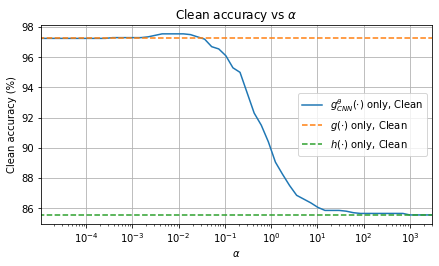

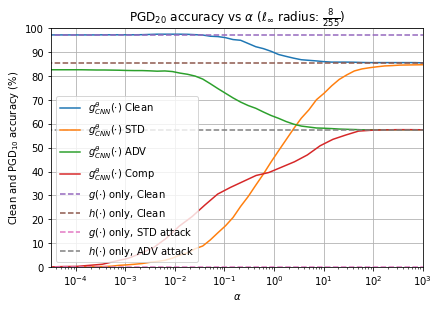

In [ ]:
#@title Use accelerated STD+ADV GradNorm and SoftMax

# Experiment settings
std_model, adv_model = ConvNextTforCIFAR(), WideResNet()
root_dir =
std_path = join(root_dir, "Pretrained/Base/ConvNeXT_CIFAR10.pt")
adv_path = join(root_dir, "Pretrained/Base/model_cifar_trade.pt")

pgd_type = 'l_inf'
comp_model_setting = {"use_gradnorm_std": True, "use_gradnorm_adv": True,
                      "accelerate": True, "use_sm": True,
                      "attack_type": pgd_type}
batch_size = {"Train": 80, "Test": 80}
pgd_setting = {"type": pgd_type, "eps": 8./255., "alpha": .0027, "iters": 20}
alpha_setting = {"min": -4.5, "max": 3,
                 "num": {"Clean": 50, "STD": 50, "ADV": 50, "Comp": 30}}
save_dir = join(root_dir, "Results", "CompareGrad", "ResNet_AT_Linf_BothGN")

# Run experiments
std_model = load_model(std_model, std_path)
adv_model = load_model(adv_model, adv_path)
run_evals(std_model, adv_model, comp_model_setting, 
          alpha_setting, pgd_setting, batch_size, 200, save_dir)

Files already downloaded and verified
Number of test images: 2000.
Files already downloaded and verified
Evaluating the STD model.


100%|██████████| 25/25 [01:03<00:00,  2.55s/it, CleanAcc=97.2, AttackedAcc=0]


Accuracy of the STD model on 10000 Clean test images: 97.250 %.
Accuracy of the STD model on 10000 Attacked test images: 0.000 %.
Evaluating the ADV model.


100%|██████████| 25/25 [00:20<00:00,  1.25it/s, CleanAcc=85.5, AttackedAcc=57.5]


Accuracy of the ADV model on 10000 Clean test images: 85.550 %.
Accuracy of the ADV model on 10000 Attacked test images: 57.500 %.
Evaluating the adaptively smoothed model.
Attack targeting base models.


100%|██████████| 25/25 [01:30<00:00,  3.61s/it]


Accuracy of the smoothed model with Clean data: 
[97.45, 97.5, 97.6, 97.6, 97.6, 97.6, 97.75, 97.7, 97.7, 97.55, 97.3, 97.05, 96.85000000000001, 96.8, 96.5, 96.2, 95.5, 94.85, 94.39999999999999, 93.95, 93.05, 92.10000000000001, 91.2, 90.2, 89.8, 89.1, 88.4, 87.85, 87.25, 87.05000000000001, 86.65, 86.45, 86.25, 86.15, 86.0, 85.95, 85.95, 85.85000000000001, 85.85000000000001, 85.75, 85.75, 85.7, 85.65, 85.65, 85.65, 85.65, 85.65, 85.65, 85.65, 85.65].
Accuracy of the smoothed model with STD data: 
[0.0, 0.0, 0.0, 0.0, 0.05, 0.1, 0.25, 0.35000000000000003, 0.5499999999999999, 0.8999999999999999, 1.4500000000000002, 1.6, 1.9, 2.3, 2.85, 3.6999999999999997, 5.050000000000001, 6.45, 8.4, 10.95, 13.900000000000002, 16.6, 19.950000000000003, 24.099999999999998, 28.349999999999998, 33.25, 37.15, 41.15, 45.35, 49.65, 54.300000000000004, 58.5, 62.45, 66.25, 69.25, 72.25, 75.0, 76.8, 78.85, 80.15, 81.69999999999999, 82.45, 83.1, 83.5, 83.8, 84.05, 84.35000000000001, 84.39999999999999, 84.5, 84.65]

25it [8:32:01, 1228.84s/it]


Accuracy of the smoothed model with Comp data: 
[0.0, 0.0, 0.0, 0.1, 0.35000000000000003, 1.4500000000000002, 5.1499999999999995, 10.15, 18.35, 25.35, 30.349999999999998, 33.95, 36.8, 38.3, 39.7, 40.75, 42.15, 43.8, 46.1, 48.85, 51.1, 52.849999999999994, 54.35, 55.65, 56.49999999999999, 56.85, 57.3, 57.45, 57.45, 57.45].


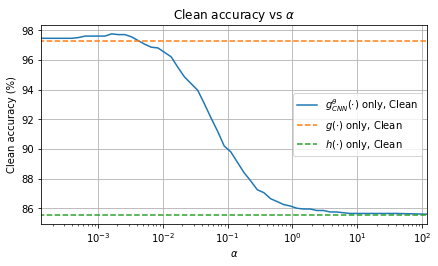

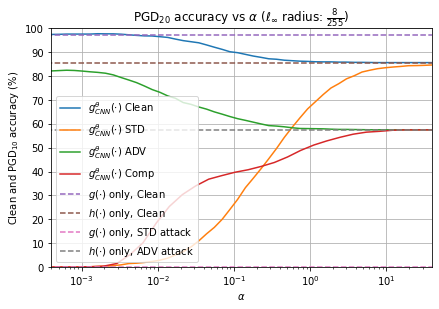

In [ ]:
#@title Use accelerated STD GradNorm and SoftMax

# Experiment settings
std_model, adv_model = ConvNextTforCIFAR(), WideResNet()
root_dir =
std_path = join(root_dir, "Pretrained/Base/ConvNeXT_CIFAR10.pt")
adv_path = join(root_dir, "Pretrained/Base/model_cifar_trade.pt")

pgd_type = 'l_inf'
comp_model_setting = {"use_gradnorm_std": True, "use_gradnorm_adv": False,
                      "accelerate": True, "use_sm": True, 
                      "attack_type": pgd_type}
batch_size = {"Train": 80, "Test": 80}
pgd_setting = {"type": pgd_type, "eps": 8./255., "alpha": .0027, "iters": 20}
alpha_setting = {"min": -3.4, "max": 1.6,
                 "num": {"Clean": 50, "STD": 50, "ADV": 50, "Comp": 30}}
save_dir = join(root_dir, "Results/CompareGrad/ConvNeXT_TRADE_Linf_STDGN")

# Run experiments
std_model = load_model(std_model, std_path)
adv_model = load_model(adv_model, adv_path)
run_evals(std_model, adv_model, comp_model_setting, 
          alpha_setting, pgd_setting, batch_size, 200, save_dir)

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


  0%|          | 0.00/109M [00:00<?, ?B/s]

Files already downloaded and verified
Number of test images: 2000.
Files already downloaded and verified
Evaluating the STD model.


100%|██████████| 25/25 [01:03<00:00,  2.54s/it, CleanAcc=97.2, AttackedAcc=0]


Accuracy of the STD model on 10000 Clean test images: 97.250 %.
Accuracy of the STD model on 10000 Attacked test images: 0.000 %.
Evaluating the ADV model.


100%|██████████| 25/25 [00:20<00:00,  1.25it/s, CleanAcc=85.5, AttackedAcc=57.5]


Accuracy of the ADV model on 10000 Clean test images: 85.550 %.
Accuracy of the ADV model on 10000 Attacked test images: 57.500 %.
Evaluating the adaptively smoothed model.
Attack targeting base models.


100%|██████████| 25/25 [01:30<00:00,  3.60s/it]


Accuracy of the smoothed model with Clean data: 
[97.45, 97.5, 97.6, 97.6, 97.6, 97.6, 97.75, 97.7, 97.7, 97.55, 97.3, 97.05, 96.85000000000001, 96.8, 96.5, 96.2, 95.5, 94.85, 94.39999999999999, 93.95, 93.05, 92.10000000000001, 91.2, 90.2, 89.8, 89.1, 88.4, 87.85, 87.25, 87.05000000000001, 86.65, 86.45, 86.25, 86.15, 86.0, 85.95, 85.95, 85.85000000000001, 85.85000000000001, 85.75, 85.75, 85.7, 85.65, 85.65, 85.65, 85.65, 85.65, 85.65, 85.65, 85.65].
Accuracy of the smoothed model with STD data: 
[0.0, 0.0, 0.0, 0.0, 0.05, 0.1, 0.25, 0.35000000000000003, 0.5499999999999999, 0.8999999999999999, 1.4500000000000002, 1.6, 1.9, 2.3, 2.85, 3.6999999999999997, 5.050000000000001, 6.45, 8.4, 10.95, 13.900000000000002, 16.6, 19.950000000000003, 24.099999999999998, 28.349999999999998, 33.25, 37.15, 41.15, 45.35, 49.65, 54.300000000000004, 58.5, 62.45, 66.25, 69.25, 72.25, 75.0, 76.8, 78.85, 80.15, 81.69999999999999, 82.45, 83.1, 83.5, 83.8, 84.05, 84.35000000000001, 84.39999999999999, 84.5, 84.65]

25it [8:30:16, 1224.66s/it]


Accuracy of the smoothed model with Comp data: 
[0.0, 0.0, 0.0, 0.1, 0.35000000000000003, 1.8499999999999999, 5.3, 11.05, 18.95, 25.55, 30.75, 34.699999999999996, 36.449999999999996, 38.15, 39.5, 40.8, 42.199999999999996, 43.65, 46.050000000000004, 49.2, 51.349999999999994, 52.849999999999994, 54.35, 55.75, 56.599999999999994, 56.89999999999999, 57.35, 57.45, 57.49999999999999, 57.49999999999999].


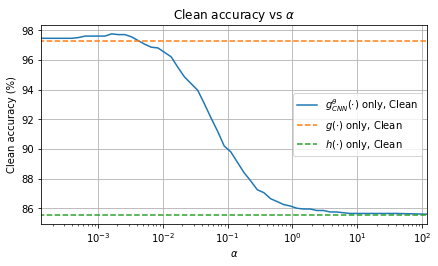

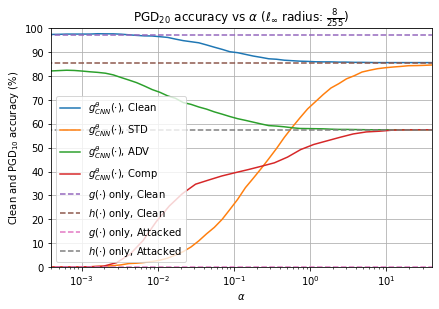

In [16]:
#@title Use accelerated STD GradNorm and SoftMax

# Experiment settings
std_model, adv_model = ConvNextTforCIFAR(), WideResNet()
root_dir =
std_path = join(root_dir, "Pretrained/Base/ConvNeXT_CIFAR10.pt")
adv_path = join(root_dir, "Pretrained/Base/model_cifar_trade.pt")

pgd_type = 'l_inf'
comp_model_setting = {"use_gradnorm_std": True, "use_gradnorm_adv": False,
                      "accelerate": True, "use_sm": True, 
                      "attack_type": pgd_type}
batch_size = {"Train": 80, "Test": 80}
pgd_setting = {"type": pgd_type, "eps": 8./255., "alpha": .0027, "iters": 20}
alpha_setting = {"min": -3.4, "max": 1.6,
                 "num": {"Clean": 50, "STD": 50, "ADV": 50, "Comp": 30}}
save_dir = join(root_dir, "Results/CompareGrad/ConvNeXT_TRADE_Linf_STDGN")

# Run experiments
std_model = load_model(std_model, std_path)
adv_model = load_model(adv_model, adv_path)
run_evals(std_model, adv_model, comp_model_setting, 
          alpha_setting, pgd_setting, batch_size, 200, save_dir)

Files already downloaded and verified
Number of test images: 2000.
Files already downloaded and verified
Evaluating the STD model.


100%|██████████| 16/16 [01:02<00:00,  3.92s/it, CleanAcc=97.2, AttackedAcc=0]


Accuracy of the STD model on 10000 Clean test images: 97.250 %.
Accuracy of the STD model on 10000 Attacked test images: 0.000 %.
Evaluating the ADV model.


100%|██████████| 16/16 [00:19<00:00,  1.20s/it, CleanAcc=85.5, AttackedAcc=57.5]


Accuracy of the ADV model on 10000 Clean test images: 85.550 %.
Accuracy of the ADV model on 10000 Attacked test images: 57.550 %.
Evaluating the adaptively smoothed model.
Attack targeting base models.


100%|██████████| 16/16 [01:23<00:00,  5.23s/it]


Accuracy of the smoothed model with Clean data: 
[97.35000000000001, 97.35000000000001, 97.35000000000001, 97.39999999999999, 97.39999999999999, 97.39999999999999, 97.39999999999999, 97.45, 97.5, 97.5, 97.5, 97.6, 97.6, 97.7, 97.7, 97.65, 97.75, 97.6, 97.55, 97.35000000000001, 96.89999999999999, 96.45, 96.0, 95.3, 94.6, 93.5, 92.5, 91.7, 91.25, 90.5, 89.85, 89.0, 88.5, 87.9, 87.64999999999999, 87.3, 86.9, 86.9, 86.55000000000001, 86.4, 86.4, 86.3, 86.15, 86.0, 85.85000000000001, 85.85000000000001, 85.85000000000001, 85.85000000000001, 85.85000000000001, 85.8].
Accuracy of the smoothed model with STD data: 
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.15, 0.35000000000000003, 0.6, 1.6, 27.400000000000002, 41.85, 52.2, 59.35, 65.3, 69.55, 72.95, 75.7, 78.3, 79.45, 80.4, 81.0, 81.89999999999999, 82.19999999999999, 82.89999999999999, 83.1, 83.35000000000001, 83.55, 83.8, 83.95, 84.0, 84.05, 84.15, 84.2, 84.25, 84.5, 84.65, 84.65, 84.65, 84.65, 84.65].
Accur

16it [52:55, 198.46s/it]


Accuracy of the smoothed model with Comp data: 
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.75, 1.6500000000000001, 17.1, 29.2, 36.8, 42.5, 46.5, 49.1, 51.349999999999994, 52.949999999999996, 54.1, 54.65, 54.75, 55.35, 55.900000000000006, 56.25, 56.35, 56.65, 56.65, 56.99999999999999, 57.099999999999994, 57.199999999999996, 57.25, 57.25, 57.4, 57.4, 57.45].


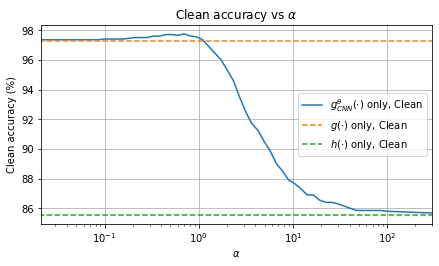

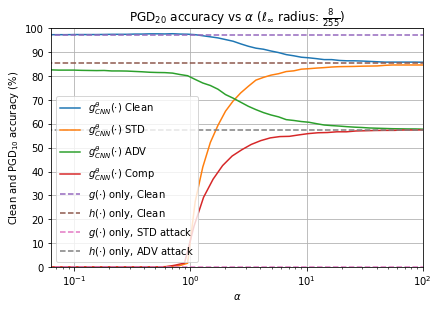

In [ ]:
#@title Use SoftMax but no GradNorm 

# Experiment settings
std_model, adv_model = ConvNextTforCIFAR(), WideResNet()
root_dir =
std_path = join(root_dir, "Pretrained/Base/ConvNeXT_CIFAR10.pt")
adv_path = join(root_dir, "Pretrained/Base/model_cifar_trade.pt")

pgd_type = 'l_inf'
comp_model_setting = {"use_gradnorm_std": False, "use_gradnorm_adv": False,
                      "accelerate": True, "use_sm": True, 
                      "attack_type": pgd_type}
batch_size = {"Train": 125, "Test": 125}
pgd_setting = {"type": pgd_type, "eps": 8./255., "alpha": .0027, "iters": 20}
alpha_setting = {"min": -1.2, "max": 2,
                 "num": {"Clean": 50, "STD": 50, "ADV": 50, "Comp": 40}}
save_dir = join(root_dir, "Results/CompareGrad/ResNet_AT_Linf_NoGN")

# Run experiments
std_model = load_model(std_model, std_path)
adv_model = load_model(adv_model, adv_path)
run_evals(std_model, adv_model, comp_model_setting, 
          alpha_setting, pgd_setting, batch_size, 200, save_dir)

Files already downloaded and verified
Number of test images: 2000.
Files already downloaded and verified
Evaluating the STD model.


100%|██████████| 16/16 [01:02<00:00,  3.93s/it, CleanAcc=97.2, AttackedAcc=0]


Accuracy of the STD model on 10000 Clean test images: 97.250 %.
Accuracy of the STD model on 10000 Attacked test images: 0.000 %.
Evaluating the ADV model.


100%|██████████| 16/16 [00:19<00:00,  1.21s/it, CleanAcc=85.5, AttackedAcc=57.5]


Accuracy of the ADV model on 10000 Clean test images: 85.550 %.
Accuracy of the ADV model on 10000 Attacked test images: 57.550 %.
Evaluating the adaptively smoothed model.
Attack targeting base models.


100%|██████████| 16/16 [01:23<00:00,  5.25s/it]


Accuracy of the smoothed model with Clean data: 
[97.39999999999999, 97.39999999999999, 97.45, 97.45, 97.5, 97.5, 97.55, 97.6, 97.6, 97.65, 97.7, 97.65, 97.65, 97.55, 97.39999999999999, 97.25, 97.1, 96.95, 96.8, 96.55, 95.85000000000001, 95.6, 94.69999999999999, 93.89999999999999, 92.85, 92.0, 91.25, 90.4, 90.0, 89.5, 88.6, 88.05, 87.5, 87.15, 87.1, 86.7, 86.65, 86.4, 86.25, 86.0, 85.95, 85.95, 85.95, 85.9, 85.85000000000001, 85.8, 85.8, 85.8, 85.8, 85.8].
Accuracy of the smoothed model with STD data: 
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.25, 0.35000000000000003, 0.6, 1.4000000000000001, 3.05, 4.55, 6.5, 9.45, 13.55, 17.75, 22.95, 29.299999999999997, 35.6, 41.8, 48.449999999999996, 53.349999999999994, 58.75, 63.7, 67.5, 70.65, 73.4, 75.1, 76.55, 77.9, 78.8, 79.85, 80.7, 81.55, 82.15, 82.65, 82.89999999999999, 83.1, 83.25, 83.35000000000001, 83.6, 83.89999999999999, 84.0, 84.1, 84.35000000000001].
Accuracy of the smoothed model with ADV data: 
[82.39999999999999, 8

16it [39:44, 149.06s/it]


Accuracy of the smoothed model with Comp data: 
[0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.05, 0.05, 0.2, 0.4, 1.0999999999999999, 2.1999999999999997, 4.9, 10.15, 17.599999999999998, 25.900000000000002, 33.650000000000006, 39.15, 44.1, 47.9, 50.1, 52.1, 53.849999999999994, 55.2, 56.10000000000001, 56.55, 56.85, 57.05, 57.099999999999994, 57.25].


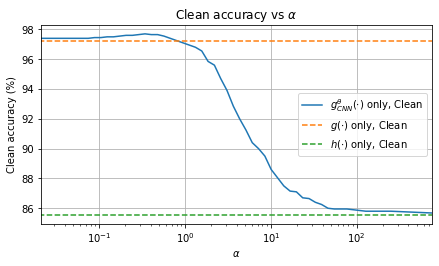

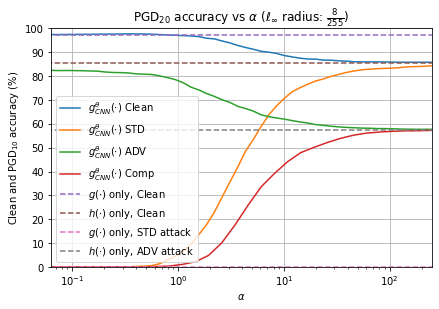

In [ ]:
#@title Use neither GradNorm nor SoftMax

# Experiment settings
std_model, adv_model = ConvNextTforCIFAR(), WideResNet()
root_dir =
std_path = join(root_dir, "Pretrained/Base/ConvNeXT_CIFAR10.pt")
adv_path = join(root_dir, "Pretrained/Base/model_cifar_trade.pt")

pgd_type = 'l_inf'
comp_model_setting = {"use_gradnorm_std": False, "use_gradnorm_adv": False,
                      "accelerate": True, "use_sm": False, 
                      "attack_type": pgd_type}
batch_size = {"Train": 125, "Test": 125}
pgd_setting = {"type": pgd_type, "eps": 8./255., "alpha": .0027, "iters": 20}
alpha_setting = {"min": -1.2, "max": 2.4,
                 "num": {"Clean": 50, "STD": 50, "ADV": 50, "Comp": 30}}
save_dir = join(root_dir, "Results/CompareGrad/ResNet_AT_Linf_NoGN_NoSM")

# Run experiments
std_model = load_model(std_model, std_path)
adv_model = load_model(adv_model, adv_path)
run_evals(std_model, adv_model, comp_model_setting, 
          alpha_setting, pgd_setting, batch_size, 200, save_dir)

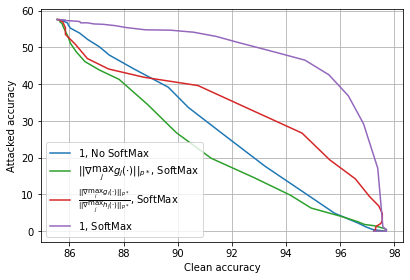

In [32]:
#@title Plot existing results
std_grad = r"$||\nabla \max_j g_j (\cdot)||_{p*}$"
both_grad = r"$\frac{||\nabla \max_i g_i (\cdot)||_{p*}}{||\nabla \max_j h_j (\cdot)||_{p*}}$"
load_dirs = {r"$1$, No SoftMax": "ConvNeXT_TRADE_Linf_NoGN_NoSM",
             std_grad + ", SoftMax": "ConvNeXT_TRADE_Linf_STDGN",
             both_grad + ", SoftMax": "ConvNeXT_TRADE_Linf_BothGN",
             r"$1$, SoftMax": "ConvNeXT_TRADE_Linf_NoGN"}
root_dir =
plt.figure(figsize=(5.8, 4))

colors = ['tab:blue', 'tab:green', 'tab:red', 'tab:purple']
for color, (legend, filename) in zip(colors, load_dirs.items()):
    load_dir = join(root_dir, filename)
    with open(join(load_dir, "results.json"), 'r') as f:
        dic = json.load(f)

    comp_acc, alpha_setting = dic["comp_acc"], dic["alpha_setting"]
    alphas = {}
    for typ in ["Clean", "STD", "ADV", "Comp"]:
        alphas[typ] = list(np.logspace(
            alpha_setting["min"], alpha_setting["max"],
            alpha_setting["num"][typ]))
    
    interp_clean = list(np.interp(alphas["Comp"], 
                                  alphas["Clean"], comp_acc["Clean"]))
    interp_stdadv = list(np.interp(alphas["Comp"], 
                                   alphas["STD"], comp_acc["STD"]))
    attacked_acc = [
        min(std, comp) for std, comp in zip(interp_stdadv, comp_acc["Comp"])]
    plt.plot([97.25] + interp_clean + [85.55], 
             [0] + attacked_acc + [57.55], '-', color=color, label=legend)

plt.legend()
plt.xlabel("Clean accuracy")
plt.ylabel("Attacked accuracy")
plt.grid()
plt.tight_layout()
plt.savefig(join(root_dir, "ConvNeXT_TRADE_Linf.pdf"))

## Clean+AT ResNet18 L2

Files already downloaded and verified
Number of test images: 2000.
Files already downloaded and verified
Evaluating the STD model.


100%|██████████| 4/4 [00:04<00:00,  1.04s/it, CleanAcc=95.1, AttackedAcc=1.6]


Accuracy of the STD model on 10000 Clean test images: 95.100 %.
Accuracy of the STD model on 10000 Attacked test images: 1.600 %.
Evaluating the ADV model.


100%|██████████| 4/4 [00:04<00:00,  1.04s/it, CleanAcc=85.3, AttackedAcc=64.5]


Accuracy of the ADV model on 10000 Clean test images: 85.300 %.
Accuracy of the ADV model on 10000 Attacked test images: 64.550 %.
Evaluating the adaptively smoothed model.
Attack targeting base models.


100%|██████████| 4/4 [00:08<00:00,  2.17s/it]


Accuracy of the smoothed model with Clean data: 
[95.1, 95.1, 95.1, 95.1, 95.1, 95.1, 95.15, 95.25, 95.25, 95.3, 95.35, 95.1, 95.05, 94.89999999999999, 94.69999999999999, 94.55, 94.25, 94.25, 94.0, 94.0, 93.55, 92.85, 92.65, 92.35, 92.15, 91.75, 91.4, 90.9, 90.4, 89.64999999999999, 89.1, 88.3, 87.64999999999999, 87.2, 86.95, 86.7, 86.45, 86.15, 86.0, 85.75, 85.6, 85.5, 85.45, 85.39999999999999, 85.39999999999999, 85.35000000000001, 85.35000000000001, 85.35000000000001, 85.3, 85.3].
Accuracy of the smoothed model with STD data: 
[3.15, 3.25, 3.5999999999999996, 3.8, 3.85, 4.2, 4.35, 4.75, 4.95, 5.3, 5.65, 6.0, 6.5, 6.8500000000000005, 7.249999999999999, 7.75, 8.35, 9.3, 10.4, 11.4, 12.049999999999999, 13.15, 14.2, 15.45, 16.8, 18.05, 20.05, 22.3, 24.4, 26.75, 29.5, 32.35, 35.15, 38.550000000000004, 42.35, 45.7, 48.949999999999996, 53.0, 56.89999999999999, 59.9, 63.0, 66.3, 69.05, 72.65, 74.95, 77.25, 79.05, 80.15, 80.95, 81.69999999999999].
Accuracy of the smoothed model with ADV data: 

4it [29:12, 438.00s/it]


Accuracy of the smoothed model with Comp data: 
[2.9499999999999997, 3.05, 3.65, 4.2, 5.050000000000001, 6.15, 6.950000000000001, 8.5, 10.2, 12.0, 13.850000000000001, 16.650000000000002, 21.5, 29.75, 38.95, 47.25, 53.400000000000006, 57.95, 60.3, 61.9, 63.14999999999999, 63.9, 64.2, 64.25, 64.3, 64.3, 64.4, 64.5, 64.5, 64.55].


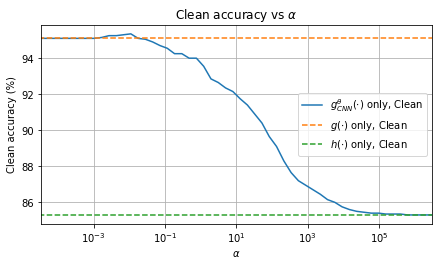

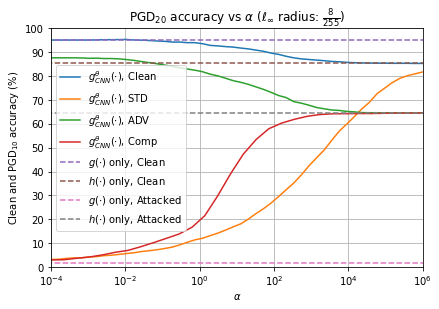

In [5]:
#@title Use accelerated STD+ADV GradNorm and SoftMax

# Experiment settings
std_model, adv_model = ResNet18(), ResNet18()
root_dir = "/content/drive/MyDrive/Adaptive Smoothing"
std_path = join(root_dir, "Pretrained/Base/CIFAR-10_basic_training_.pt")
adv_path = join(root_dir, "Pretrained/Base/l2_robust_model.pt")

pgd_type = 'l_2'
comp_model_setting = {"use_gradnorm_std": True, "use_gradnorm_adv": True,
                      "accelerate": True, "use_sm": True,
                      "attack_type": pgd_type}
batch_size = {"Train": 500, "Test": 500}
pgd_setting = {"type": pgd_type, "eps": .5, "alpha": .075, "iters": 30}
alpha_setting = {"min": -4, "max": 6,
                 "num": {"Clean": 50, "STD": 50, "ADV": 50, "Comp": 30}}
save_dir = join(root_dir, "Results", "CompareGrad", "ResNet_AT_L2_BothGN")

# Run experiments
std_model = load_model(std_model, std_path)
adv_model = load_model(adv_model, adv_path)
run_evals(std_model, adv_model, comp_model_setting, 
          alpha_setting, pgd_setting, batch_size, 200, save_dir)

Files already downloaded and verified
Number of test images: 2000.
Files already downloaded and verified
Evaluating the STD model.


100%|██████████| 4/4 [00:03<00:00,  1.32it/s, CleanAcc=95.1, AttackedAcc=3.15]


Accuracy of the STD model on 10000 Clean test images: 95.100 %.
Accuracy of the STD model on 10000 Attacked test images: 3.150 %.
Evaluating the ADV model.


100%|██████████| 4/4 [00:02<00:00,  1.38it/s, CleanAcc=85.3, AttackedAcc=64.7]


Accuracy of the ADV model on 10000 Clean test images: 85.300 %.
Accuracy of the ADV model on 10000 Attacked test images: 64.650 %.
Evaluating the adaptively smoothed model.
Attack targeting base models.


100%|██████████| 4/4 [00:05<00:00,  1.49s/it]


Accuracy of the smoothed model with Clean data: 
[95.15, 95.15, 95.25, 95.3, 95.3, 95.19999999999999, 95.25, 95.1, 95.05, 94.89999999999999, 94.65, 94.45, 94.35, 94.1, 94.0, 94.0, 93.85, 93.55, 93.05, 92.65, 92.45, 92.15, 91.75, 91.45, 91.0, 90.7, 90.14999999999999, 89.64999999999999, 89.2, 88.4, 87.9, 87.45, 87.15, 86.95, 86.7, 86.35000000000001, 86.1, 85.95, 85.9, 85.65, 85.5, 85.45, 85.45, 85.39999999999999, 85.39999999999999, 85.35000000000001, 85.35000000000001, 85.35000000000001, 85.35000000000001, 85.3].
Accuracy of the smoothed model with STD data: 
[3.15, 3.2, 3.25, 3.25, 3.35, 3.45, 3.5999999999999996, 3.75, 4.0, 4.3, 4.9, 5.5, 5.8500000000000005, 6.550000000000001, 7.000000000000001, 7.55, 7.95, 8.3, 8.6, 9.2, 9.85, 10.5, 11.25, 12.55, 13.25, 14.45, 15.4, 16.7, 18.4, 20.95, 23.25, 25.8, 28.65, 32.0, 34.9, 39.15, 43.8, 47.599999999999994, 52.15, 56.599999999999994, 60.85, 64.95, 67.9, 71.39999999999999, 74.45, 76.35, 77.8, 78.8, 80.0, 80.80000000000001].
Accuracy of the smoot

4it [11:02, 165.60s/it]


Accuracy of the smoothed model with Comp data: 
[3.2, 3.1, 3.35, 3.45, 3.6999999999999997, 4.3, 5.1, 6.05, 6.6000000000000005, 7.8, 9.2, 11.25, 16.900000000000002, 25.25, 35.6, 44.5, 51.24999999999999, 56.45, 59.45, 61.550000000000004, 62.74999999999999, 63.800000000000004, 64.3, 64.3, 64.3, 64.45, 64.5, 64.60000000000001, 64.64999999999999, 64.64999999999999].


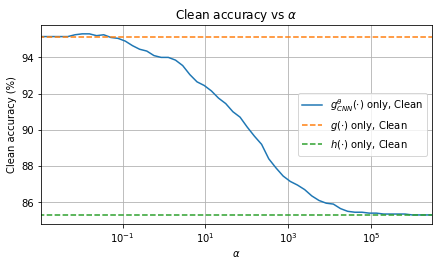

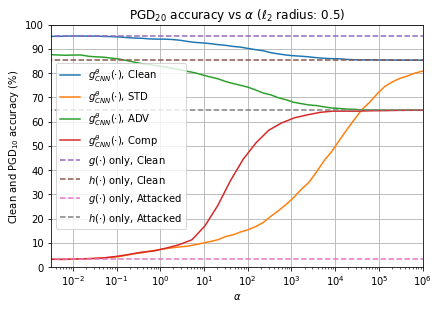

In [10]:
#@title Use accelerated STD GradNorm and SoftMax

# Experiment settings
std_model, adv_model = ResNet18(), ResNet18()
root_dir =
std_path = join(root_dir, "Pretrained/Base/CIFAR-10_basic_training_.pt")
adv_path = join(root_dir, "Pretrained/Base/l2_robust_model.pt")

pgd_type = 'l_2'
comp_model_setting = {"use_gradnorm_std": True, "use_gradnorm_adv": False,
                      "accelerate": True, "use_sm": True, 
                      "attack_type": pgd_type}
batch_size = {"Train": 500, "Test": 500}
pgd_setting = {"type": pgd_type, "eps": .5, "alpha": .075, "iters": 20}
alpha_setting = {"min": -2.5, "max": 6,
                 "num": {"Clean": 50, "STD": 50, "ADV": 50, "Comp": 30}}
save_dir = join(root_dir, "Results/CompareGrad/ResNet_AT_L2_STDGN")

# Run experiments
std_model = load_model(std_model, std_path)
adv_model = load_model(adv_model, adv_path)
run_evals(std_model, adv_model, comp_model_setting, 
          alpha_setting, pgd_setting, batch_size, 200, save_dir)

Files already downloaded and verified
Number of test images: 2000.
Files already downloaded and verified
Evaluating the STD model.


100%|██████████| 3/3 [00:02<00:00,  1.05it/s, CleanAcc=95.1, AttackedAcc=3.05]


Accuracy of the STD model on 10000 Clean test images: 95.100 %.
Accuracy of the STD model on 10000 Attacked test images: 3.050 %.
Evaluating the ADV model.


100%|██████████| 3/3 [00:02<00:00,  1.06it/s, CleanAcc=85.3, AttackedAcc=64.7]


Accuracy of the ADV model on 10000 Clean test images: 85.300 %.
Accuracy of the ADV model on 10000 Attacked test images: 64.650 %.
Evaluating the adaptively smoothed model.
Attack targeting base models.


100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


Accuracy of the smoothed model with Clean data: 
[95.1, 95.1, 95.1, 95.1, 95.1, 95.1, 95.1, 95.15, 95.15, 95.15, 95.15, 95.15, 95.15, 95.15, 95.15, 95.19999999999999, 95.25, 95.25, 95.25, 95.3, 95.3, 95.25, 95.19999999999999, 95.15, 95.3, 94.95, 94.05, 93.5, 92.60000000000001, 91.85, 91.35, 90.25, 89.8, 89.35, 88.7, 87.94999999999999, 87.7, 87.55, 87.05000000000001, 86.7, 86.65, 86.3, 86.05000000000001, 85.95, 85.9, 85.8, 85.8, 85.6, 85.5, 85.45].
Accuracy of the smoothed model with STD data: 
[3.15, 3.15, 3.15, 3.15, 3.15, 3.15, 3.15, 3.15, 3.2, 3.2, 3.2, 3.2, 3.3000000000000003, 3.4000000000000004, 3.45, 3.5000000000000004, 3.5000000000000004, 3.6999999999999997, 3.8, 3.9, 4.15, 4.35, 4.8, 5.35, 6.35, 47.199999999999996, 60.150000000000006, 66.14999999999999, 71.0, 74.65, 77.14999999999999, 78.55, 80.15, 81.05, 81.89999999999999, 82.45, 82.85, 83.35000000000001, 83.6, 83.8, 83.89999999999999, 84.0, 84.1, 84.15, 84.15, 84.2, 84.25, 84.25, 84.25, 84.3].
Accuracy of the smoothed model w

3it [04:11, 83.95s/it]


Accuracy of the smoothed model with Comp data: 
[3.55, 3.75, 3.85, 3.9, 4.2, 4.7, 4.7, 5.25, 5.949999999999999, 6.65, 7.5, 8.55, 9.45, 11.1, 12.8, 14.099999999999998, 15.7, 17.349999999999998, 18.95, 20.3, 22.45, 24.45, 26.950000000000003, 28.599999999999998, 30.85, 51.55, 57.05, 60.0, 62.8, 64.35, 65.75, 66.3, 66.64999999999999, 66.45, 66.60000000000001, 66.60000000000001, 66.10000000000001, 66.2, 66.0, 65.8, 65.64999999999999, 65.75, 65.7, 65.64999999999999, 65.45, 65.55, 65.10000000000001, 65.10000000000001, 65.10000000000001, 65.05].


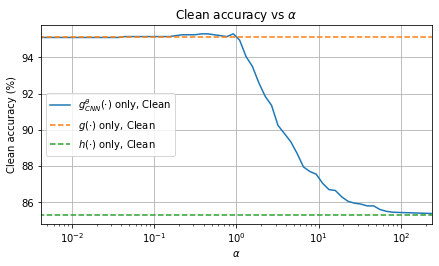

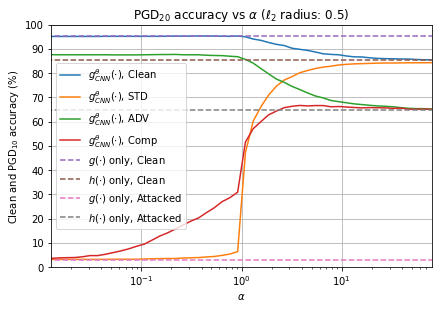

In [13]:
#@title Use SoftMax but no GradNorm 

# Experiment settings
std_model, adv_model = ResNet18(), ResNet18()
root_dir =
std_path = join(root_dir, "Pretrained/Base/CIFAR-10_basic_training_.pt")
adv_path = join(root_dir, "Pretrained/Base/l2_robust_model.pt")

pgd_type = 'l_2'
comp_model_setting = {"use_gradnorm_std": False, "use_gradnorm_adv": False,
                      "accelerate": True, "use_sm": True, 
                      "attack_type": pgd_type}
batch_size = {"Train": 680, "Test": 680}
pgd_setting = {"type": pgd_type, "eps": .5, "alpha": .075, "iters": 20}
alpha_setting = {"min": -1.9, "max": 1.9,
                 "num": {"Clean": 50, "STD": 50, "ADV": 50, "Comp": 50}}
save_dir = join(root_dir, "Results/CompareGrad/ResNet_AT_L2_NoGN")

# Run experiments
std_model = load_model(std_model, std_path)
adv_model = load_model(adv_model, adv_path)
run_evals(std_model, adv_model, comp_model_setting, 
          alpha_setting, pgd_setting, batch_size, 200, save_dir)

Files already downloaded and verified
Number of test images: 2000.
Files already downloaded and verified
Evaluating the STD model.


100%|██████████| 3/3 [00:02<00:00,  1.05it/s, CleanAcc=95.1, AttackedAcc=3.1]


Accuracy of the STD model on 10000 Clean test images: 95.100 %.
Accuracy of the STD model on 10000 Attacked test images: 3.100 %.
Evaluating the ADV model.


100%|██████████| 3/3 [00:02<00:00,  1.06it/s, CleanAcc=85.3, AttackedAcc=64.7]


Accuracy of the ADV model on 10000 Clean test images: 85.300 %.
Accuracy of the ADV model on 10000 Attacked test images: 64.650 %.
Evaluating the adaptively smoothed model.
Attack targeting base models.


100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


Accuracy of the smoothed model with Clean data: 
[95.1, 95.1, 95.15, 95.15, 95.19999999999999, 95.25, 95.3, 95.3, 95.25, 95.19999999999999, 95.19999999999999, 95.25, 95.3, 95.19999999999999, 95.15, 94.95, 94.95, 94.75, 94.5, 94.19999999999999, 94.1, 93.7, 93.2, 92.95, 92.65, 92.30000000000001, 91.8, 91.4, 90.8, 90.2, 89.60000000000001, 89.4, 88.7, 88.44999999999999, 88.35, 87.94999999999999, 87.5, 87.15, 86.9, 86.8, 86.55000000000001, 86.15, 86.05000000000001, 86.0, 85.8, 85.8, 85.8, 85.75, 85.5, 85.45].
Accuracy of the smoothed model with STD data: 
[4.45, 4.6, 4.8, 5.1, 5.35, 5.7, 6.35, 6.65, 7.049999999999999, 7.6499999999999995, 8.35, 8.95, 10.100000000000001, 10.9, 12.4, 14.45, 16.25, 19.15, 22.6, 26.150000000000002, 31.25, 36.65, 41.3, 45.5, 50.74999999999999, 54.900000000000006, 59.0, 62.8, 65.0, 67.75, 70.3, 72.65, 74.25, 76.55, 77.95, 78.75, 80.0, 81.05, 81.45, 82.0, 82.35, 82.8, 83.15, 83.45, 83.65, 83.8, 83.89999999999999, 83.89999999999999, 84.0, 84.1].
Accuracy of the smoo

3it [02:31, 50.38s/it]


Accuracy of the smoothed model with Comp data: 
[3.75, 3.6999999999999997, 4.25, 4.6, 4.7, 4.8, 5.1499999999999995, 5.949999999999999, 6.65, 7.75, 9.3, 12.0, 16.75, 23.0, 29.25, 37.4, 43.5, 48.5, 52.6, 55.75, 59.050000000000004, 61.199999999999996, 62.25000000000001, 63.14999999999999, 63.800000000000004, 64.3, 64.64999999999999, 65.0, 64.9, 64.9].


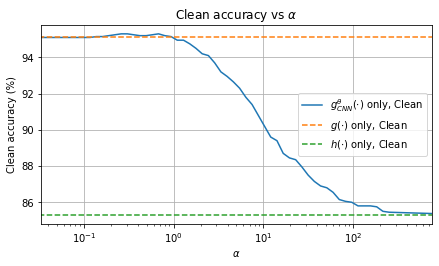

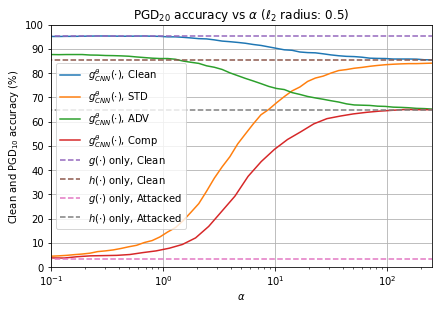

In [11]:
#@title Use neither GradNorm nor SoftMax

# Experiment settings
std_model, adv_model = ResNet18(), ResNet18()
root_dir =
std_path = join(root_dir, "Pretrained/Base/CIFAR-10_basic_training_.pt")
adv_path = join(root_dir, "Pretrained/Base/l2_robust_model.pt")

pgd_type = 'l_2'
comp_model_setting = {"use_gradnorm_std": False, "use_gradnorm_adv": False,
                      "accelerate": True, "use_sm": False, 
                      "attack_type": pgd_type}
batch_size = {"Train": 680, "Test": 680}
pgd_setting = {"type": pgd_type, "eps": .5, "alpha": .075, "iters": 20}
alpha_setting = {"min": -1, "max": 2.4,
                 "num": {"Clean": 50, "STD": 50, "ADV": 50, "Comp": 30}}
save_dir = join(root_dir, "Results/CompareGrad/ResNet_AT_L2_NoGN_NoSM")

# Run experiments
std_model = load_model(std_model, std_path)
adv_model = load_model(adv_model, adv_path)
run_evals(std_model, adv_model, comp_model_setting, 
          alpha_setting, pgd_setting, batch_size, 200, save_dir)

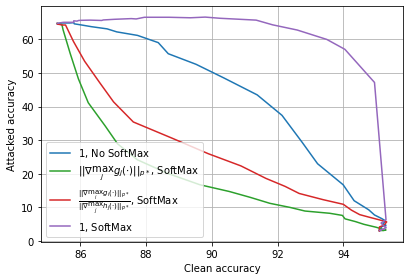

In [33]:
#Plot existing results
std_grad = r"$||\nabla \max_j g_j (\cdot)||_{p*}$"
both_grad = r"$\frac{||\nabla \max_i g_i (\cdot)||_{p*}}{||\nabla \max_j h_j (\cdot)||_{p*}}$"
load_dirs = {r"$1$, No SoftMax": "ResNet_AT_L2_NoGN_NoSM",
             std_grad + ", SoftMax": "ResNet_AT_L2_STDGN",
             both_grad + ", SoftMax": "ResNet_AT_L2_BothGN",
             r"$1$, SoftMax": "ResNet_AT_L2_NoGN"}
root_dir =
plt.figure(figsize=(5.8, 4))

colors = ['tab:blue', 'tab:green', 'tab:red', 'tab:purple']
for color, (legend, filename) in zip(colors, load_dirs.items()):
    load_dir = join(root_dir, filename)
    with open(join(load_dir, "results.json"), 'r') as f:
        dic = json.load(f)

    comp_acc, alpha_setting = dic["comp_acc"], dic["alpha_setting"]
    alphas = {}
    for typ in ["Clean", "STD", "ADV", "Comp"]:
        alphas[typ] = list(np.logspace(
            alpha_setting["min"], alpha_setting["max"],
            alpha_setting["num"][typ]))
        
    interp_clean = list(np.interp(alphas["Comp"], 
                                  alphas["Clean"], comp_acc["Clean"]))
    interp_stdadv = list(np.interp(alphas["Comp"], 
                                   alphas["STD"], comp_acc["STD"]))
    attacked_acc = [
        min(std, comp) for std, comp in zip(interp_stdadv, comp_acc["Comp"])]
    plt.plot([95.1] + interp_clean + [85.3], 
             [3.1] + attacked_acc + [64.76], '-', color=color, label=legend)

plt.legend()
plt.xlabel("Clean accuracy")
plt.ylabel("Attacked accuracy")
plt.grid()
plt.tight_layout()
plt.savefig(join(root_dir, "ResNet_AT_L2.pdf"))